In [1]:
## BBC Category Dataset from Kaggle

In [202]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/My Drive/bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [204]:
df.category.unique() #mencari tahu banyak category pada dataset

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [205]:
df_baru = df #backup data

In [206]:
df_baru.columns

Index(['category', 'text'], dtype='object')

In [207]:
desc = df_baru['text']
label = df_baru['category']

In [208]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [209]:
from sklearn.model_selection import train_test_split
head_train, head_test, label_train, label_test = train_test_split(desc, label, test_size=0.2,random_state=0)

In [210]:
#mengubah data categorical kedalam bentuk angka
encoder = LabelEncoder()
y_train = encoder.fit_transform(label_train)
y_test = encoder.transform(label_test)


In [211]:
num_classes = np.max(y_train) + 1 #mencari tahu banyaknya category

In [212]:
label_train = to_categorical(y_train, num_classes)
label_test = to_categorical(y_test, num_classes)

In [213]:
#hyperparameter untuk tokenisasi
max_length = 200
trunc_type = 'post'
padding_type = 'post'

In [214]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=2000, oov_token='-', lower=True)
tokenizer.fit_on_texts(head_train)
tokenizer.fit_on_texts(head_test)

seq_train = tokenizer.texts_to_sequences(head_train)
seq_test = tokenizer.texts_to_sequences(head_test)

padded_train = pad_sequences(seq_train,maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_test = pad_sequences(seq_test,maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [215]:
size = len(tokenizer.word_index) + 1
size

29728

In [216]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [217]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [218]:
embedding_matrix = np.zeros((size, 100))

# mengisi nilai embedded_matrix
for word, i in tokenizer.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # mendapatkan embedded vector dari pretrained model Glove
    if embedding_vector is not None:
        # menambahkan ke matrix embedding
        embedding_matrix[i] = embedding_vector # ditambahkan ke setiap row

In [219]:
import tensorflow as tf
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=29728, output_dim=100, input_length=30 , weights=[embedding_matrix], trainable=False),
                             tf.keras.layers.LSTM(512),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(num_classes, activation='softmax')

              
])


model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 30, 100)           2972800   
_________________________________________________________________
lstm_26 (LSTM)               (None, 512)               1255424   
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_45 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 5)               

In [220]:
num_epochs = 50
history = model.fit(
    padded_train, label_train,
    validation_split = 0.2,
    epochs=num_epochs, batch_size=50)

Epoch 1/50
29/29 [==============================] - 4s 135ms/step - loss: 1.4626 - accuracy: 0.3806 - val_loss: 1.6424 - val_accuracy: 0.3202
Epoch 2/50
29/29 [==============================] - 3s 113ms/step - loss: 1.3187 - accuracy: 0.4775 - val_loss: 1.1367 - val_accuracy: 0.4972
Epoch 3/50
29/29 [==============================] - 3s 113ms/step - loss: 1.0551 - accuracy: 0.5695 - val_loss: 1.0472 - val_accuracy: 0.6096
Epoch 4/50
29/29 [==============================] - 3s 114ms/step - loss: 0.9093 - accuracy: 0.6615 - val_loss: 0.7599 - val_accuracy: 0.7388
Epoch 5/50
29/29 [==============================] - 3s 114ms/step - loss: 0.8717 - accuracy: 0.6861 - val_loss: 0.8798 - val_accuracy: 0.6938
Epoch 6/50
29/29 [==============================] - 3s 114ms/step - loss: 0.9005 - accuracy: 0.6917 - val_loss: 0.8406 - val_accuracy: 0.7472
Epoch 7/50
29/29 [==============================] - 3s 113ms/step - loss: 0.8125 - accuracy: 0.6994 - val_loss: 0.8173 - val_accuracy: 0.7416
Epoch 

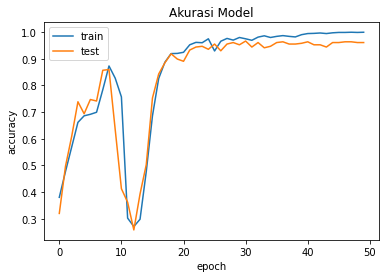

In [221]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

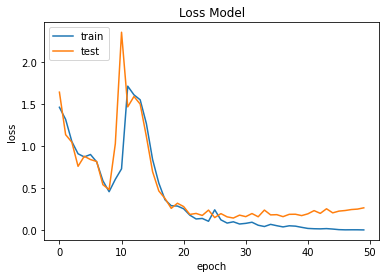

In [222]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()